In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs

In [5]:
train_loader, test_loader = mnist()

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1e-4)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [0]:
def train(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        for name, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [0]:
models = {'F.softmax': Net(), 'log_softmax': Net(True)}
test_log = {k: [] for k in models}

In [0]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, len(test_loader.dataset), p)
line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

def test(models, log=None):
    test_size = len(test_loader.sampler)
    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in test_loader:
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models.keys():
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models.keys():
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [50]:
for epoch in range(1, 11):
    train(epoch, models)
    test(models, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses F.softmax: 2.333026 log_softmax: 2.328404
Train Epoch: 1 [10000/60000 (17%)]	Losses F.softmax: 2.304454 log_softmax: 2.351367
Train Epoch: 1 [20000/60000 (33%)]	Losses F.softmax: 2.307875 log_softmax: 2.265439
Train Epoch: 1 [30000/60000 (50%)]	Losses F.softmax: 2.324386 log_softmax: 2.350862
Train Epoch: 1 [40000/60000 (67%)]	Losses F.softmax: 2.304071 log_softmax: 2.339390
Train Epoch: 1 [50000/60000 (83%)]	Losses F.softmax: 2.301562 log_softmax: 2.306597
Train Epoch: 1 [60000/60000 (100%)]	Losses F.softmax: 2.291391 log_softmax: 2.295553
Test set:
F.softmax: Loss: 2.3008	Accuracy: 1491.0/10000 (15%)
log_softmax: Loss: 2.3104	Accuracy: 1032.0/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Losses F.softmax: 2.300987 log_softmax: 2.286285
Train Epoch: 2 [10000/60000 (17%)]	Losses F.softmax: 2.308978 log_softmax: 2.310853
Train Epoch: 2 [20000/60000 (33%)]	Losses F.softmax: 2.304718 log_softmax: 2.280292
Train Epoch: 2 [30000/60000 (50%)]	Losses F.softma

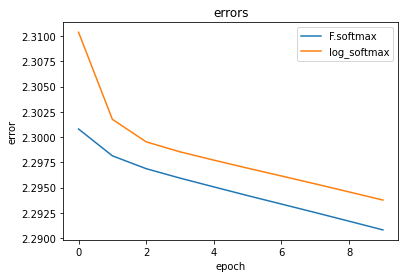

In [51]:
plot_graphs(test_log, 'loss')

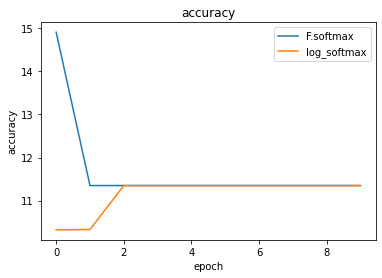

In [52]:
plot_graphs(test_log, 'accuracy')

In [53]:
test_log

{'F.softmax': [(2.300801170349121, tensor(14.9100)),
  (2.298148207092285, tensor(11.3500)),
  (2.296874924468994, tensor(11.3500)),
  (2.295943187713623, tensor(11.3500)),
  (2.2950742240905764, tensor(11.3500)),
  (2.294212865447998, tensor(11.3500)),
  (2.2933764183044434, tensor(11.3500)),
  (2.2925359367370604, tensor(11.3500)),
  (2.2916807815551756, tensor(11.3500)),
  (2.290818647003174, tensor(11.3500))],
 'log_softmax': [(2.3103711952209474, tensor(10.3200)),
  (2.3017579887390136, tensor(10.3300)),
  (2.2995300186157226, tensor(11.3500)),
  (2.2985433555603025, tensor(11.3500)),
  (2.2977212989807128, tensor(11.3500)),
  (2.2969280960083007, tensor(11.3500)),
  (2.296152828216553, tensor(11.3500)),
  (2.295371549987793, tensor(11.3500)),
  (2.2945752883911132, tensor(11.3500)),
  (2.2937734153747558, tensor(11.3500))]}